https://www.kevinsheppard.com/teaching/python/notes/notebooks/example-gjr-garch/

## This example will highlight the steps needed to estimate the parameters of a GJR-GARCH(1,1,1) model with a constant mean. The volatility dynamics in a GJR-GARCH model are given by

$\sigma_{t}^{2}=\omega+\sum_{i=1}^{p}\alpha_{i}\epsilon_{t-i}^{2}+\sum_{j=1}^{o}\gamma_{j}r_{t-j}^{2}I_{\left[\epsilon_{t-j}<0\right]}+\sum_{k=1}^{q}\beta_{k}\sigma_{t-k}^{2}$

Optimization terminated successfully    (Exit mode 0)
            Current function value: 9569.030507603133
            Iterations: 12
            Function evaluations: 89
            Gradient evaluations: 12
Parameter   Estimate       Std. Err.      T-stat
mu          0.032146        0.010084     3.18795
omega       0.017610        0.003330     5.28813
alpha       0.030658        0.006730     4.55564
gamma       0.091709        0.012944     7.08484
beta        0.906327        0.009784     92.62951


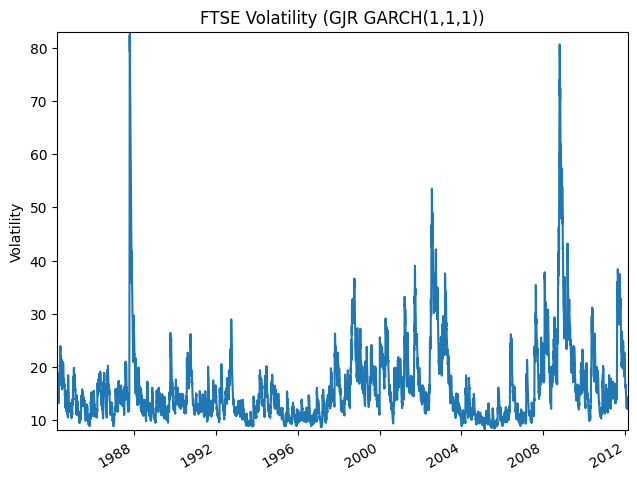

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy import size, log, pi, sum, array, zeros, diag, mat, asarray, sqrt, copy
from numpy.linalg import inv
from scipy.optimize import fmin_slsqp

# Define the GJR-GARCH likelihood function
def gjr_garch_likelihood(parameters, data, sigma2, out=None):
    ''' Returns negative log-likelihood for GJR-GARCH(1,1,1) model.'''
    mu = parameters[0]
    omega = parameters[1]
    alpha = parameters[2]
    gamma = parameters[3]
    beta = parameters[4]

    T = size(data, 0)
    eps = data - mu

    for t in range(1, T):
        sigma2[t] = (omega + alpha * eps[t-1]**2
                     + gamma * eps[t-1]**2 * (eps[t-1]<0) + beta * sigma2[t-1])

    logliks = 0.5 * (log(2*pi) + log(sigma2) + eps**2 / sigma2)
    loglik = sum(logliks)

    if out is None:
        return loglik
    else:
        return loglik, logliks, copy(sigma2)

# Define the constraint function for optimization
def gjr_constraint(parameters, data, sigma2, out=None):
    ''' Constraint that alpha + gamma/2 + beta <= 1'''
    alpha = parameters[2]
    gamma = parameters[3]
    beta = parameters[4]
    return array([1 - alpha - gamma/2 - beta])

# Define the 2-sided numerical Hessian approximation function
def hessian_2sided(fun, theta, args):
    f = fun(theta, *args)
    h = 1e-5 * np.abs(theta)
    thetah = theta + h
    h = thetah - theta
    K = size(theta, 0)
    h = np.diag(h)

    fp = zeros(K)
    fm = zeros(K)
    for i in range(K):
        fp[i] = fun(theta + h[i], *args)
        fm[i] = fun(theta - h[i], *args)

    fpp = zeros((K, K))
    fmm = zeros((K, K))
    for i in range(K):
        for j in range(i, K):
            fpp[i, j] = fun(theta + h[i] + h[j], *args)
            fpp[j, i] = fpp[i, j]
            fmm[i, j] = fun(theta - h[i] - h[j], *args)
            fmm[j, i] = fmm[i, j]

    hh = (diag(h))
    hh = hh.reshape((K, 1))
    hh = hh @ hh.T

    H = zeros((K, K))
    for i in range(K):
        for j in range(i, K):
            H[i, j] = (fpp[i, j] - fp[i] - fp[j] + f
                       + f - fm[i] - fm[j] + fmm[i, j]) / hh[i, j] / 2
            H[j, i] = H[i, j]

    return H

# Load and preprocess data
url = 'https://raw.githubusercontent.com/kboroz/TimeSeriesPredictionWS2023/main/FTSE_1984_2012.csv'

FTSE = pd.read_csv(url, parse_dates=[0])
FTSE.index = FTSE.pop('Date')
FTSE = FTSE.iloc[::-1]
FTSEprice = FTSE['Adj Close']
FTSEreturn = 100 * FTSEprice.pct_change().dropna()

# Set starting values
startingVals = array([FTSEreturn.mean(),
                      FTSEreturn.var() * .01,
                      .03, .09, .90])

# Set bounds for optimization
finfo = np.finfo(np.float64)
bounds = [(-10 * FTSEreturn.mean(), 10 * FTSEreturn.mean()),
          (finfo.eps, 2 * FTSEreturn.var()),
          (0.0, 1.0), (0.0, 1.0), (0.0, 1.0)]

# Initialize sigma2 vector
T = FTSEreturn.shape[0]
sigma2 = np.ones(T) * FTSEreturn.var()
args = (np.asarray(FTSEreturn), sigma2)

# Optimize parameters using fmin_slsqp
estimates = fmin_slsqp(gjr_garch_likelihood, startingVals,
                       f_ieqcons=gjr_constraint, bounds=bounds,
                       args=args)

# Compute log-likelihood and variances
loglik, logliks, sigma2final = gjr_garch_likelihood(estimates, FTSEreturn, sigma2, out=True)

# Compute numerical scores and covariance of scores
step = 1e-5 * estimates
scores = zeros((T, 5))

for i in range(5):
    h = step[i]
    delta = np.zeros(5)
    delta[i] = h

    loglik, logliksplus, sigma2 = gjr_garch_likelihood(estimates + delta,
                                                       np.asarray(FTSEreturn), sigma2, out=True)
    loglik, logliksminus, sigma2 = gjr_garch_likelihood(estimates - delta,
                                                        np.asarray(FTSEreturn), sigma2, out=True)

    scores[:, i] = (logliksplus - logliksminus) / (2 * h)

I = (scores.T @ scores) / T

# Compute Hessian and asymptotic covariance
J = hessian_2sided(gjr_garch_likelihood, estimates, args)
J = J / T
Jinv = mat(inv(J))
vcv = Jinv * mat(I) * Jinv / T
vcv = asarray(vcv)

# Pretty print the results
output = np.vstack((estimates, sqrt(diag(vcv)), estimates / sqrt(diag(vcv)))).T
print('Parameter   Estimate       Std. Err.      T-stat')
param = ['mu', 'omega', 'alpha', 'gamma', 'beta']

for i in range(len(param)):
    print('{0:<11} {1:>0.6f}        {2:0.6f}    {3: 0.5f}'.format(param[i],
           output[i, 0], output[i, 1], output[i, 2]))

# Plot the annualized conditional standard deviations
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

dates = FTSE.index[1:]
fig = plt.figure()
ax = fig.add_subplot(111)
volatility = pd.DataFrame(np.sqrt(252 * sigma2), index=dates)
ax.plot(volatility.index, volatility)
ax.autoscale(tight='x')
fig.autofmt_xdate()
fig.tight_layout(pad=1.5)
ax.set_ylabel('Volatility')
ax.set_title('FTSE Volatility (GJR GARCH(1,1,1))')
plt.show()
